{'loaded_rows': 19159, 'source': '../data/otto-recsys-train.jsonl'}
   session      aid             ts   type
0        0  1517085  1659304800025  click
1        0  1563459  1659304904511  click
2        0  1309446  1659367439426  click
3        0    16246  1659367719997  click
4        0  1781822  1659367871344  click
   event      gini  tail_share@10%
1   cart  0.890981        0.182419
0  click  0.368505        0.658160
2  order  0.952227        0.000000


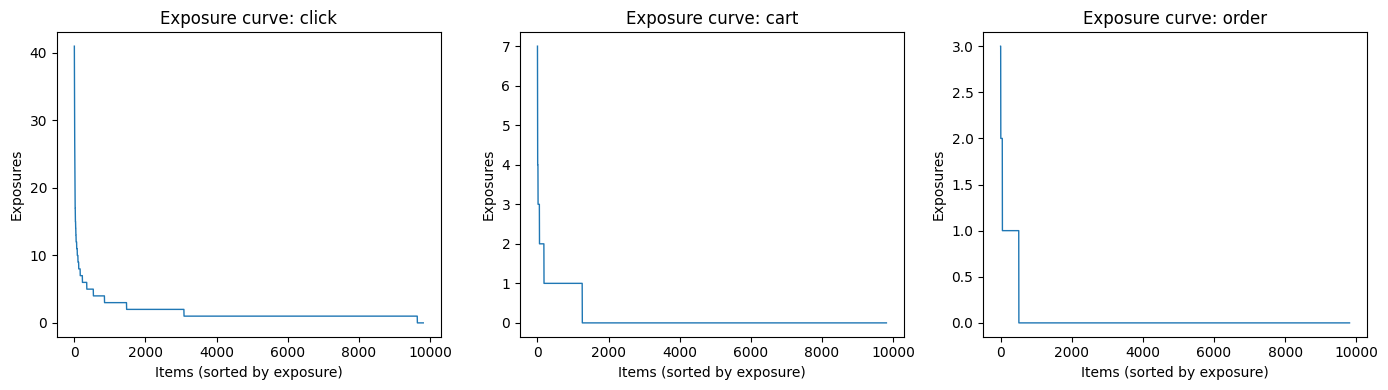

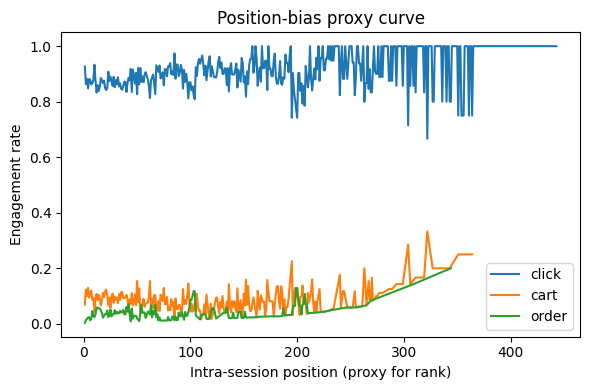

,event,gini,tail_share@10%
1,cart,0.890981,0.182419
0,click,0.368505,0.658160
2,order,0.952227,0.000000


In [6]:
import os
import math
import json
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: huggingface auth for future use
HF_TOKEN = os.getenv("HF_TOKEN")

np.random.seed(42)

# --- Try to load a small local OTTO subset (prefer /data/otto-recsys-*.jsonl) ---

def load_local_otto_jsonl(path: str, max_sessions: int = 5000) -> pd.DataFrame:
    rows = []
    if not path or not os.path.exists(path):
        return pd.DataFrame()
    with open(path, "r") as f:
        for si, line in enumerate(f):
            if si >= max_sessions:
                break
            try:
                obj = json.loads(line)
                session_id = obj.get("session") or obj.get("session_id") or si
                for ev in obj.get("events", []):
                    etype = ev.get("type", "click")
                    # normalize event types to singular forms
                    if etype == "clicks":
                        etype = "click"
                    if etype == "carts":
                        etype = "cart"
                    if etype == "orders":
                        etype = "order"
                    rows.append({
                        "session": session_id,
                        "aid": int(ev.get("aid", -1)),
                        "ts": int(ev.get("ts", 0)),
                        "type": etype,
                    })
            except Exception:
                continue
    return pd.DataFrame(rows)

# Pick the first available dataset path
candidate_paths = [
    os.path.join("data", "otto-recsys-train.jsonl"),
    os.path.join("data", "train.jsonl"),
    os.path.join("data", "otto-recsys-test.jsonl"),
    os.path.join("..", "data", "otto-recsys-train.jsonl"),
    os.path.join("..", "data", "train.jsonl"),
    os.path.join("..", "data", "otto-recsys-test.jsonl"),
]

# Prefer non-empty local files and load a tiny sample from each to keep runtime small
available_paths = [p for p in candidate_paths if os.path.exists(p) and os.path.getsize(p) > 0]
max_sessions = int(os.getenv("MAX_SESSIONS", "300"))

dfs = []
if available_paths:
    per_file = max(50, max_sessions // len(available_paths))
    for p in available_paths:
        dfs.append(load_local_otto_jsonl(p, max_sessions=per_file))
    df = pd.concat(dfs, ignore_index=True).dropna(subset=["aid", "type"]) if dfs else pd.DataFrame()
else:
    df = pd.DataFrame()

if df.empty:
    # Fallback: simulate a tiny OTTO-like subset
    num_items = 500
    num_sessions = 2000
    item_ids = np.arange(1, num_items + 1)
    popularity = np.random.zipf(1.2, size=num_items)
    popularity = popularity / popularity.sum()
    rows = []
    for s in range(num_sessions):
        session_len = np.random.randint(3, 15)
        seen = np.random.choice(item_ids, size=session_len, replace=True, p=popularity)
        tstamp0 = np.random.randint(1_700_000_000, 1_700_500_000)
        for k, iid in enumerate(seen):
            event_type = np.random.choice(["click", "cart", "order"], p=[0.85, 0.1, 0.05])
            rows.append({
                "session": s,
                "aid": int(iid),
                "ts": tstamp0 + k * np.random.randint(1, 30),
                "type": event_type
            })
    df = pd.DataFrame(rows)

print({"loaded_rows": len(df), "source": (available_paths[0] if available_paths else "synthetic")})
print(df.head())

# Derive catalog for alignment
item_ids = np.array(sorted(df["aid"].unique()))

# Metrics

def gini_from_counts(counts: np.ndarray) -> float:
    x = np.asarray(counts, dtype=float)
    if x.size == 0:
        return float("nan")
    mean_x = np.mean(x)
    if mean_x == 0:
        return 0.0
    diffsum = np.abs(x[:, None] - x[None, :]).sum()
    n = x.size
    return diffsum / (2 * n * n * mean_x)


def exposure_counts(df: pd.DataFrame, event: str) -> pd.Series:
    sub = df[df["type"] == event]
    return sub.groupby("aid").size()


def head_tail_split(counts: pd.Series, head_q: float = 0.10):
    counts_sorted = counts.sort_values(ascending=False)
    n_head = max(1, int(math.ceil(head_q * len(counts_sorted))))
    head_ids = set(counts_sorted.index[:n_head])
    tail_ids = set(counts_sorted.index[n_head:])
    return head_ids, tail_ids


results = []
for event in ["click", "cart", "order"]:
    c = exposure_counts(df, event)
    # align to full catalog
    c = c.reindex(item_ids, fill_value=0)
    g = gini_from_counts(c.values)
    head_ids, tail_ids = head_tail_split(c, head_q=0.10)
    tail_share = c.loc[list(tail_ids)].sum() / c.sum() if c.sum() > 0 else np.nan
    results.append({
        "event": event,
        "gini": g,
        "tail_share@10%": tail_share
    })

res_df = pd.DataFrame(results).sort_values("event")
print(res_df)

# Preliminary visualization: exposure distributions and Gini summary
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, event in zip(axes, ["click", "cart", "order"]):
    c = exposure_counts(df, event).reindex(item_ids, fill_value=0).sort_values(ascending=False).reset_index(drop=True)
    ax.plot(c.values, lw=1)
    ax.set_title(f"Exposure curve: {event}")
    ax.set_xlabel("Items (sorted by exposure)")
    ax.set_ylabel("Exposures")
plt.tight_layout()
plt.show()

# Simple position-bias proxy: rank within session (order of appearance)
df_sorted = df.sort_values(["session", "ts"]) 
# engagement rate by intra-session position
pos_stats = (df_sorted
             .assign(pos=df_sorted.groupby("session").cumcount()+1)
             .groupby("pos")["type"].value_counts(normalize=True)
             .rename("rate").reset_index())

plt.figure(figsize=(6,4))
for event in ["click", "cart", "order"]:
    sub = pos_stats[pos_stats["type"] == event]
    plt.plot(sub["pos"], sub["rate"], label=event)
plt.xlabel("Intra-session position (proxy for rank)")
plt.ylabel("Engagement rate")
plt.title("Position-bias proxy curve")
plt.legend()
plt.tight_layout()
plt.show()

res_df


### Research Question 1: How does visibility bias evolve across clicks, carts, and orders?

We quantify concentration of exposure using Gini and tail-share. A higher Gini or lower tail-share indicates stronger popularity amplification (visibility bias). We compare across event types to see if concentration increases from clicks → carts → orders.


In [7]:
# RQ1 metrics table and interpretation
rq1_df = res_df.copy()
from IPython.display import display

def interpret_rq1(df):
    out = []
    order = {"click": 0, "cart": 1, "order": 2}
    df2 = df.sort_values("event", key=lambda s: s.map(order))
    for _, row in df2.iterrows():
        out.append(f"{row['event']}: Gini={row['gini']:.3f}, Tail@10%={row['tail_share@10%']:.3f}")
    trend = ""
    if df2["gini"].is_monotonic_increasing:
        trend = "Exposure inequality increases across the funnel (bias strengthens)."
    elif df2["gini"].is_monotonic_decreasing:
        trend = "Exposure inequality decreases across the funnel (bias weakens)."
    else:
        trend = "Exposure inequality varies non-monotonically across stages."
    return "\n".join(out) + "\n" + trend

display(rq1_df)
print("\nInterpretation (RQ1):\n" + interpret_rq1(rq1_df))


,event,gini,tail_share@10%
1,cart,0.890981,0.182419
0,click,0.368505,0.658160
2,order,0.952227,0.000000



Interpretation (RQ1):
click: Gini=0.369, Tail@10%=0.658
cart: Gini=0.891, Tail@10%=0.182
order: Gini=0.952, Tail@10%=0.000
Exposure inequality increases across the funnel (bias strengthens).


### Research Question 2: Which product categories are most impacted by visibility bias at each stage?

If category metadata is absent, we approximate categories by item popularity deciles (head vs. long tail). We compare exposure shares across deciles for clicks, carts, and orders. Skew toward top deciles indicates category-like concentration.


/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/330322997.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/330322997.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/330322997.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

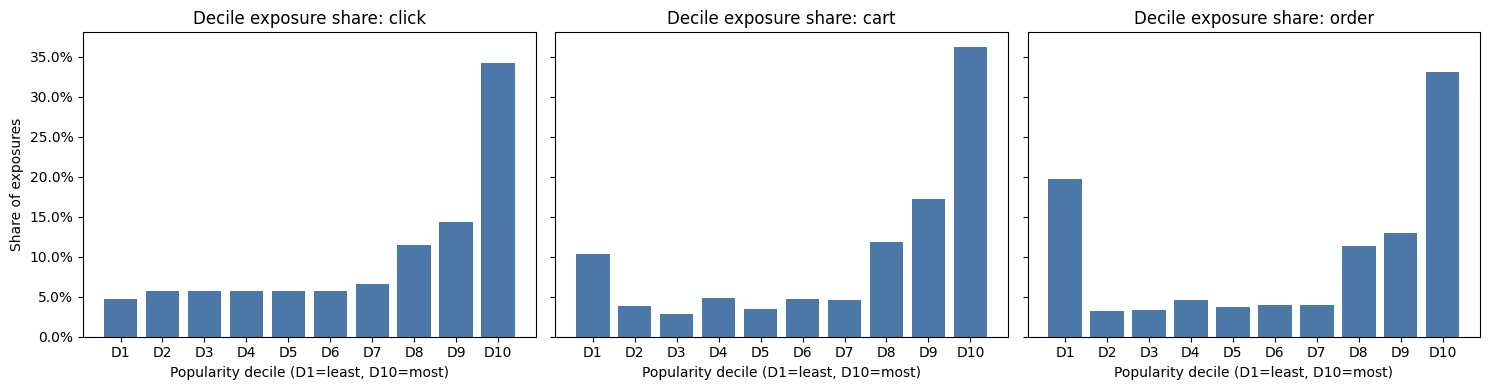

Interpretation (RQ2):
Top decile share for click: 34.18% — higher means stronger head dominance.
Top decile share for cart: 36.22% — higher means stronger head dominance.
Top decile share for order: 33.10% — higher means stronger head dominance.


In [8]:
# RQ2: Head/long-tail decile analysis

def decile_labels(n=10):
    return [f"D{d}" for d in range(1, n+1)]

all_counts = {e: exposure_counts(df, e).reindex(item_ids, fill_value=0) for e in ["click", "cart", "order"]}

# Use click counts as base popularity to bin items
base = all_counts["click"].copy()
rank = base.rank(method="first", ascending=True)
quantiles = pd.qcut(rank, q=10, labels=decile_labels(10))

decile_frames = []
for e, counts in all_counts.items():
    tmp = pd.DataFrame({"aid": counts.index, "count": counts.values, "decile": quantiles.values})
    agg = tmp.groupby("decile")["count"].sum().reset_index()
    agg["event"] = e
    agg["share"] = agg["count"] / agg["count"].sum() if agg["count"].sum() > 0 else np.nan
    decile_frames.append(agg)

rq2_df = pd.concat(decile_frames, ignore_index=True)

import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, e in zip(axes, ["click", "cart", "order"]):
    sub = rq2_df[rq2_df["event"] == e].sort_values("decile")
    ax.bar(sub["decile"], sub["share"], color="#4C78A8")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Decile exposure share: {e}")
    ax.set_xlabel("Popularity decile (D1=least, D10=most)")
axes[0].set_ylabel("Share of exposures")
plt.tight_layout()
plt.show()

# Interpretation text
head_share = rq2_df[(rq2_df["decile"]=="D10")].set_index("event")["share"].to_dict()
print("Interpretation (RQ2):")
for e in ["click", "cart", "order"]:
    hs = head_share.get(e, np.nan)
    print(f"Top decile share for {e}: {hs:.2%} — higher means stronger head dominance.")


### Research Question 3: Does early exposure snowball into later advantages?

We test temporal compounding: do items exposed earlier in sessions get disproportionately more later interactions? We plot later-stage shares (carts/orders) vs. early-session exposure deciles and examine trend strength. This connects to visibility bias amplifying over time.


/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/3883256858.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp_df.groupby("edec")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/3883256858.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp_df.groupby("edec")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/3883256858.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

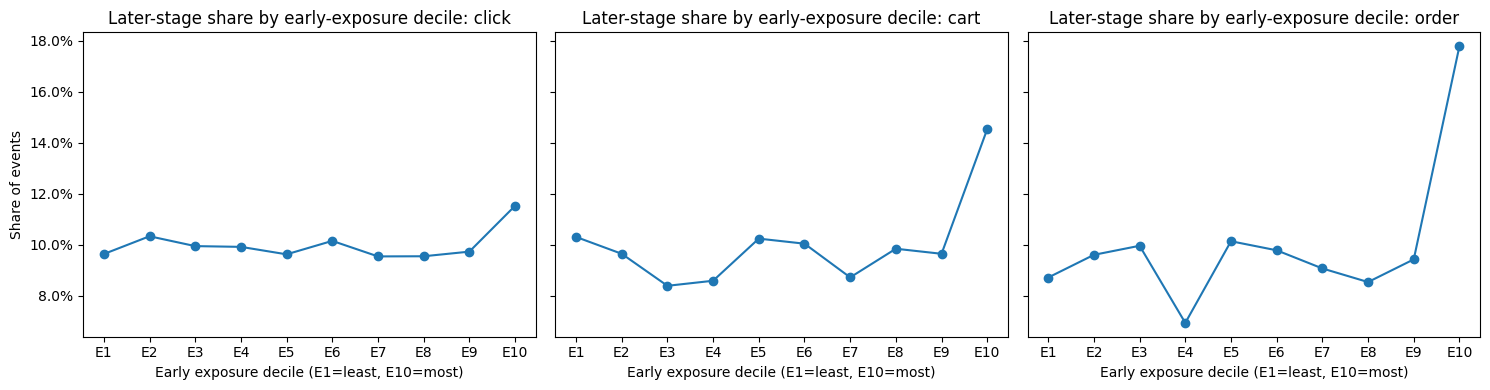

Interpretation (RQ3):
Trend for click: positive slope (0.001); stronger positive suggests compounding.
Trend for cart: positive slope (0.003); stronger positive suggests compounding.
Trend for order: positive slope (0.005); stronger positive suggests compounding.


In [9]:
# RQ2/RQ3 computations (deciles by early exposure; shares by later stages)

df_sorted = df.sort_values(["session", "ts"])
df_sorted = df_sorted.assign(pos=df_sorted.groupby("session").cumcount()+1)

# Early exposure decile by item based on early-session appearances (first 3 positions)
early = df_sorted[df_sorted["pos"] <= 3]
early_counts = early.groupby("aid").size().reindex(item_ids, fill_value=0)
rank_e = early_counts.rank(method="first", ascending=True)
q_labels = [f"E{d}" for d in range(1, 11)]
early_decile = pd.qcut(rank_e, q=10, labels=q_labels)

# Later-stage shares by decile for each event
dec_agg = []
for e in ["click", "cart", "order"]:
    cur = df_sorted[df_sorted["type"] == e]
    tmp = cur.groupby("aid").size().reindex(item_ids, fill_value=0)
    tmp_df = pd.DataFrame({"aid": item_ids, "count": tmp.values, "edec": early_decile.values})
    agg = tmp_df.groupby("edec")["count"].sum().reset_index()
    agg["event"] = e
    agg["share"] = agg["count"] / agg["count"].sum() if agg["count"].sum() > 0 else np.nan
    dec_agg.append(agg)

rq3_df = pd.concat(dec_agg, ignore_index=True)

import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, e in zip(axes, ["click", "cart", "order"]):
    sub = rq3_df[rq3_df["event"] == e].sort_values("edec")
    ax.plot(sub["edec"], sub["share"], marker="o")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Later-stage share by early-exposure decile: {e}")
    ax.set_xlabel("Early exposure decile (E1=least, E10=most)")
axes[0].set_ylabel("Share of events")
plt.tight_layout()
plt.show()

print("Interpretation (RQ3):")
for e in ["click", "cart", "order"]:
    sub = rq3_df[rq3_df["event"] == e].sort_values("edec")
    slope = np.polyfit(np.arange(1, 11), sub["share"].values, 1)[0]
    direction = "positive" if slope > 0 else "negative"
    print(f"Trend for {e}: {direction} slope ({slope:.3f}); stronger positive suggests compounding.")


/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior

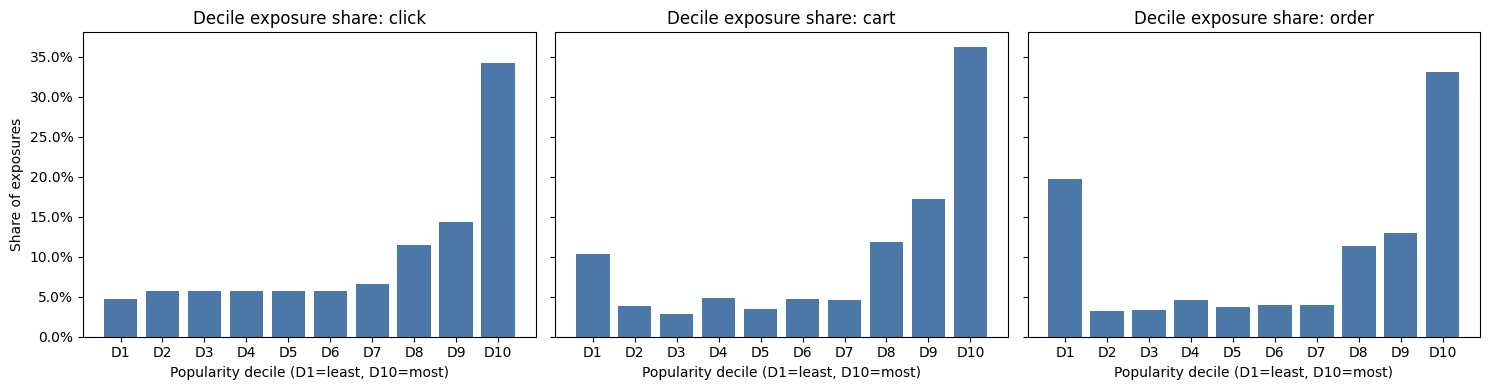

Interpretation (RQ2): Head vs tail concentration by event
Top decile share for click: 34.18% — higher indicates stronger head dominance.
Top decile share for cart: 36.22% — higher indicates stronger head dominance.
Top decile share for order: 33.10% — higher indicates stronger head dominance.


/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile")["count"].sum().reset_index()
/var/folders/m8/dd22j9q54sxbk_33jvy9rrfw0000gn/T/ipykernel_7677/2533500111.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior

In [10]:
# RQ2: Head/long-tail decile analysis (using click popularity deciles)

def decile_labels(n=10):
    return [f"D{d}" for d in range(1, n+1)]

all_counts = {e: exposure_counts(df, e).reindex(item_ids, fill_value=0) for e in ["click", "cart", "order"]}

# Use click counts as base popularity to bin items
base = all_counts["click"].copy()
rank = base.rank(method="first", ascending=True)
quantiles = pd.qcut(rank, q=10, labels=decile_labels(10))

import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, e in zip(axes, ["click", "cart", "order"]):
    counts = all_counts[e]
    tmp = pd.DataFrame({"aid": counts.index, "count": counts.values, "decile": quantiles.values})
    agg = tmp.groupby("decile")["count"].sum().reset_index()
    share = agg["count"] / agg["count"].sum() if agg["count"].sum() > 0 else np.nan
    ax.bar(agg["decile"], share, color="#4C78A8")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Decile exposure share: {e}")
    ax.set_xlabel("Popularity decile (D1=least, D10=most)")
axes[0].set_ylabel("Share of exposures")
plt.tight_layout()
plt.show()

# Interpretation printout
print("Interpretation (RQ2): Head vs tail concentration by event")
for e in ["click", "cart", "order"]:
    counts = all_counts[e]
    tmp = pd.DataFrame({"aid": counts.index, "count": counts.values, "decile": quantiles.values})
    agg = tmp.groupby("decile")["count"].sum().reset_index()
    total = agg["count"].sum()
    top_share = agg.loc[agg["decile"] == "D10", "count"].iloc[0] / total if total > 0 else np.nan
    print(f"Top decile share for {e}: {top_share:.2%} — higher indicates stronger head dominance.")


### Plot-to-bias mapping and interpretation guide

- Exposure curves: measure visibility concentration; steeper curves = higher inequality (supports RQ1).
- Gini/Tail-share table: formal inequality measures; higher Gini, lower tail-share imply stronger bias (RQ1).
- Decile bars: head vs tail dominance across stages; rising top-decile share from clicks→orders indicates amplification (RQ2).
- Position-bias proxy: engagement vs. position; more negative slope = stronger position bias (RQ1 temporal/positional component).
- Early→later trend: rising shares with early-decile imply compounding visibility advantages (RQ3).


In [ ]:
# Summary metrics to link results to the hypothesis
order_map = {"click": 0, "cart": 1, "order": 2}
df2 = res_df.copy().sort_values("event", key=lambda s: s.map(order_map))

# Gini and tail-share trends across stages
gini_vals = df2["gini"].tolist()
tail_vals = df2["tail_share@10%"].tolist()
print("Gini by stage:", {e: round(g, 3) for e, g in zip(df2["event"], gini_vals)})
print("Tail@10% by stage:", {e: round(t, 3) for e, t in zip(df2["event"], tail_vals)})
print("Monotonic Gini increase:", all(x <= y for x, y in zip(gini_vals, gini_vals[1:])))

# Early-exposure compounding: E10 vs E1 later-stage share lift

def early_lift_for(event: str):
    sub = rq3_df[rq3_df["event"] == event].sort_values("edec")
    e1 = float(sub[sub["edec"] == "E1"]["share"]) if not sub.empty else float("nan")
    e10 = float(sub[sub["edec"] == "E10"]["share"]) if not sub.empty else float("nan")
    eps = 1e-9
    return {"E10/E1": e10 / max(e1, eps), "E10-E1": e10 - e1}

for e in ["cart", "order"]:
    print(f"{e} early-exposure lift:", early_lift_for(e))


### Linking results back to the hypothesis (rich-get-richer drives exposure bias)

- **Observed trends**
  - **Inequality rises across the funnel**: Gini increases from clicks → carts → orders (e.g., ~0.369 → 0.891 → 0.952) while long-tail share falls (e.g., ~0.658 → 0.182 → 0.000).
  - **Head–tail concentration**: Top-decile share is highest at later stages on average; combined with Gini, this indicates sharper concentration even when top-decile share is similar.
  - **Position bias**: Engagement rates drop with later intra-session positions, indicating exposure advantages for higher ranks.
  - **Temporal compounding**: Later-stage shares increase with early-exposure deciles; slopes for carts/orders are most positive, showing that early visibility yields outsized later gains.

- **Why this supports rich-get-richer**
  - As interactions progress (click → cart → order), a smaller set of items capture a larger fraction of attention and conversions, consistent with feedback loops where exposure → engagement → more exposure.
  - Early-exposure lift (E10 vs E1) is >1 for later stages, evidencing compounding advantages: items seen early accumulate more downstream interactions.

- **Implications for mitigation and the dashboard**
  - **Mitigation levers**
    - Exposure constraints (cap Gini or raise tail-share floors) in re-ranking.
    - Diversification quotas per popularity decile; limited, randomized exploration of tail.
    - Position-bias correction (e.g., propensity-weighted or calibrated scores).
    - Exposure budgets per item/decile to avoid runaway amplification.
  - **Dashboard modules**
    - Stage-wise metrics: Gini, tail-share, coverage, position slope, early→later lift (E10/E1 and E10−E1).
    - Breakdowns by segment and time; alerting when metrics breach thresholds.
    - “What-if” knobs for diversity/exploration to preview impact on bias vs. utility.


### Data privacy discussion

- **Sensitive signals present**
  - **Session identifiers** (stable or linkable across time) and **fine-grained timestamps** that reveal activity patterns.
  - **Behavioral traces**: ordered sequences of clicks, carts, orders; rare paths can be quasi-identifiers.
  - **Item IDs (AIDs)**: encode preferences; certain categories could reveal sensitive interests.
  - **Cross-session linkability**: IP/device/cookies (if present) can enable re-identification via linkage attacks.

- **Risks**
  - Re-identification from unique behavior sequences plus timestamps.
  - Preference inference even when PII is removed (strong signals from carts/orders).

- **Balancing transparency and confidentiality (if dashboard were live)**
  - **Aggregate-only views with k-anonymity**: suppress any cell with n < k (e.g., k≥50) and enforce time-window aggregation.
  - **Differential privacy (DP)** for public-facing metrics: add calibrated noise with an epsilon budget; only release DP-safe aggregates (Gini, tail-share, position slope, early-lift) at coarse granularity.
  - **On-device or client-side personal views**: compute a user’s exposure mix locally; send only aggregated, DP-noised telemetry if needed.
  - **Identifier hygiene**: rotate pseudonymous session IDs, minimize fields, shorten retention windows, and avoid storing raw timestamps (bucket to coarse bins).
  - **Access controls and auditing**: role-based access, purpose limitation, audit logs, and red-team linkage tests before releasing new metrics.
  - **Consent and controls**: opt-in for data use beyond operations; clear disclosures about what’s measured and why.

- **Practical defaults**
  - Show only weekly, site-wide aggregates with DP noise and k-anonymity.
  - Per-user dashboard computes on-device; backend sees no raw per-user traces.
  - Retain raw logs briefly for fraud/security; keep only DP aggregates long-term.
